# EDA & Preprocessing for Regression Dataset

## Setup & Imports

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px

from bagging_boosting_stacking_study.constants import SEED
from bagging_boosting_stacking_study.data.loaders import load_dataset

# dark theme across plots
pio.templates.default = "plotly_dark"
plt.style.use("dark_background")

## 1. Load Data

In [2]:
df = load_dataset("regression")

## 2. Initial Data Inspection

- Summary of dataset dimensions (number of rows and columns). For example, "The dataset contains 10,000 rows and 15 columns."
- Overview of each column’s data type (numeric, categorical, datetime), and counts of non-null entries. For instance, "Column A is numeric with 95% non-null values."
- A tally of missing values, with a quick interpretation: "Column X has 12% missing—this will require imputation or removal."
- Any immediate red flags (e.g., "Column Y has all-zero values," "Column Z has only one unique value," or "There are 50 duplicated rows").

In [3]:
# Summary of dataset dimensions
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Overview of each column’s data type and counts of non-null entries
print("\nDataFrame info:")
df.info()

# Missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
if missing_values.sum() == 0:
    print("No missing values found.")
else:
    display(missing_values[missing_values > 0])

# Check for duplicated rows
duplicated_rows = df.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicated_rows}")

Dataset contains 1000 rows and 11 columns.

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_0  1000 non-null   float64
 1   feature_1  1000 non-null   float64
 2   feature_2  1000 non-null   float64
 3   feature_3  1000 non-null   float64
 4   feature_4  1000 non-null   float64
 5   feature_5  1000 non-null   float64
 6   feature_6  1000 non-null   float64
 7   feature_7  1000 non-null   float64
 8   feature_8  1000 non-null   float64
 9   feature_9  1000 non-null   float64
 10  target     1000 non-null   float64
dtypes: float64(11)
memory usage: 86.1 KB

Missing Values:
No missing values found.

Number of duplicated rows: 0


## 3. Univariate Descriptions

- A table of descriptive statistics for each numeric column: mean, standard deviation, minimum, maximum, and quartiles.
- Highlights of features whose distributions are heavily skewed or have extreme outliers. Consider using histograms or box plots to visualize these distributions.
- A narrative on the target variable: its range, central tendency, and whether it’s approximately bell-shaped, heavy-tailed, or multimodal.
- Notes on any categorical or discrete columns: number of categories, imbalanced levels, or rare values. For example, "Category A has 90% of the data, while Category B has only 1%."

### target

In [4]:
# Descriptive statistics of the target variable
df[["target"]].describe()

,target
count,1000.000000
mean,-2.569958
std,173.703821
min,-549.585774
25%,-118.398803
50%,-3.048715
75%,116.990415
max,510.873284


In [5]:
# Skewness and kurtosis of the target variable
skewness = df["target"].skew()
kurtosis = df["target"].kurtosis()
print(f"\nSkewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")


Skewness: -0.11
Kurtosis: 0.01


Text(0.5, 1.0, 'Boxplot of Target Variable')

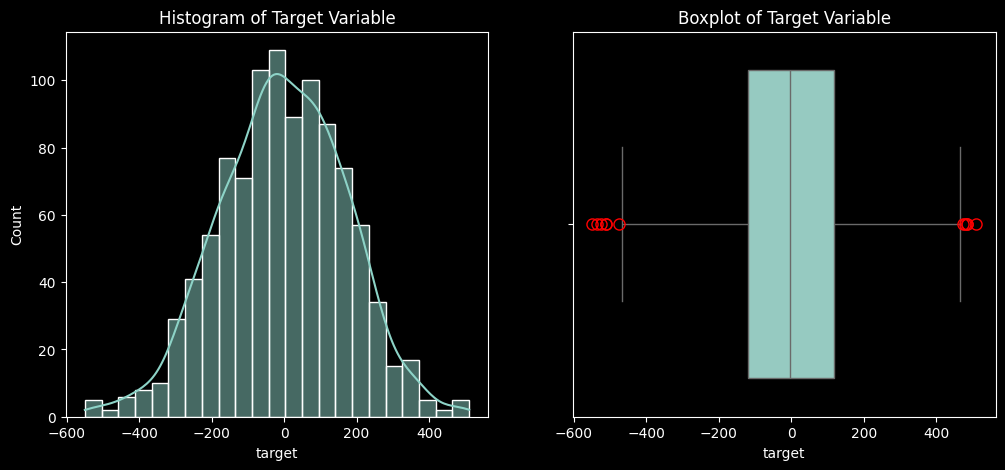

In [6]:
# Histogram and boxplot of the target variable
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Customize boxplot colors
flierprops = dict(marker="o", markeredgecolor="red", markersize=8, linestyle="none")

sns.histplot(df["target"], kde=True, ax=ax[0])
sns.boxplot(x=df["target"], ax=ax[1], flierprops=flierprops)
ax[0].set_title("Histogram of Target Variable")
ax[1].set_title("Boxplot of Target Variable")

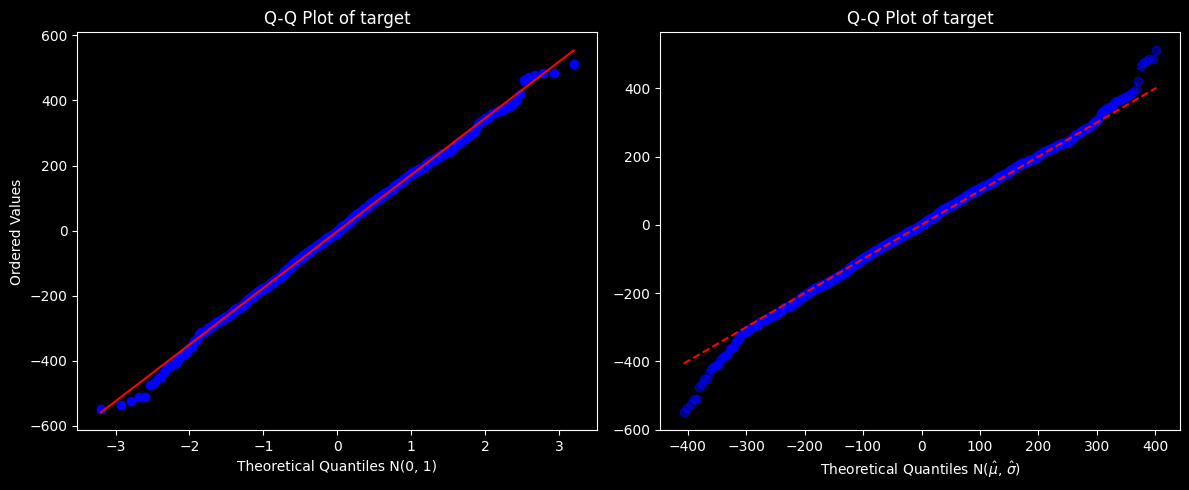

In [7]:
# Q–Q plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
stats.probplot(df["target"], dist="norm", plot=ax[0])
ax[0].set_title("Q-Q Plot of target")
ax[0].set_xlabel("Theoretical Quantiles N(0, 1)")

mu_hat = df["target"].mean()
sigma_hat = df["target"].std()
theoretical_quantiles = stats.norm.ppf(
    np.linspace(0.01, 0.99, len(df["target"])), loc=mu_hat, scale=sigma_hat
)
ax[1].scatter(theoretical_quantiles, np.sort(df["target"]), color="blue", alpha=0.5)
ax[1].plot(
    [theoretical_quantiles.min(), theoretical_quantiles.max()],
    [theoretical_quantiles.min(), theoretical_quantiles.max()],
    color="red",
    linestyle="--",
)
ax[1].set_title("Q-Q Plot of target")
ax[1].set_xlabel(r"Theoretical Quantiles N($\hat{\mu}$, $\hat{\sigma}$)")

plt.tight_layout()
plt.show()

In [8]:
# Outlier detection using Z-score and IQR for the target variable

z_scores = np.abs(stats.zscore(df["target"]))
outliers = df[(z_scores > 3) | (z_scores < -3)]
print(f"\nNumber of outliers detected using Z-score: {len(outliers)}")

q1 = df["target"].quantile(0.25)
q3 = df["target"].quantile(0.75)
iqr = q3 - q1
outliers_iqr = df[(df["target"] < (q1 - 1.5 * iqr)) | (df["target"] > (q3 + 1.5 * iqr))]
print(f"Number of outliers detected using IQR: {len(outliers_iqr)}")


Number of outliers detected using Z-score: 3
Number of outliers detected using IQR: 11


**Conclusions about the `target` variable:**

- The histogram closely follows a normal distribution, although the tails are slightly heavier than you’d expect under a perfect Gaussian.  
- In other words, the data exhibit heavy tails.  
- The mean, median, skewness and kurtosis all hover around zero.  
- I recommend **not** removing any outliers from `y`.  
- Instead, whenever possible, use modeling techniques that down-weight or are robust to outliers during fitting.


### features

In [9]:
df.drop(columns="target").describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.001572,0.031814,0.045746,-0.018796,-0.051215,0.029675,-0.048644,-0.000169,0.016618,-0.009604
std,1.002561,0.987995,0.959022,0.945498,1.001145,1.056827,0.953474,1.023710,0.989422,0.977301
min,-2.772167,-3.238225,-3.058743,-3.597388,-3.575683,-4.094310,-2.937542,-3.268089,-3.757972,-2.795434
25%,-0.678711,-0.654862,-0.635983,-0.654438,-0.708902,-0.687377,-0.691033,-0.633057,-0.691641,-0.630333
50%,0.026206,0.063444,0.040020,0.013762,-0.057959,0.028006,-0.076591,0.000901,-0.002483,-0.032677
75%,0.664547,0.677848,0.699246,0.601481,0.606776,0.726499,0.633085,0.686454,0.714803,0.633049
max,3.470995,2.807548,2.911758,3.470353,2.933371,3.243470,2.810588,3.023554,2.851715,3.047925


In [10]:
# # I commented this cell out because similar, more detailed plots are created below

# plots_per_row = 3

# p = df.shape[1] - 1
# nrows = int(np.ceil(p / plots_per_row))
# fig, ax = plt.subplots(nrows=nrows, ncols=plots_per_row, figsize=(20, 5 * nrows))

# for i, col_name in enumerate(df.drop(columns="target").columns):
#     row, col = divmod(i, plots_per_row)
#     sns.histplot(df[col_name], kde=True, ax=ax[row, col])
#     ax[row, col].set_title(col_name)

# # Remove empty subplots
# for idx in range(p, nrows * plots_per_row):
#     row, col = divmod(idx, plots_per_row)
#     fig.delaxes(ax[row, col])
# plt.tight_layout()
# plt.show()

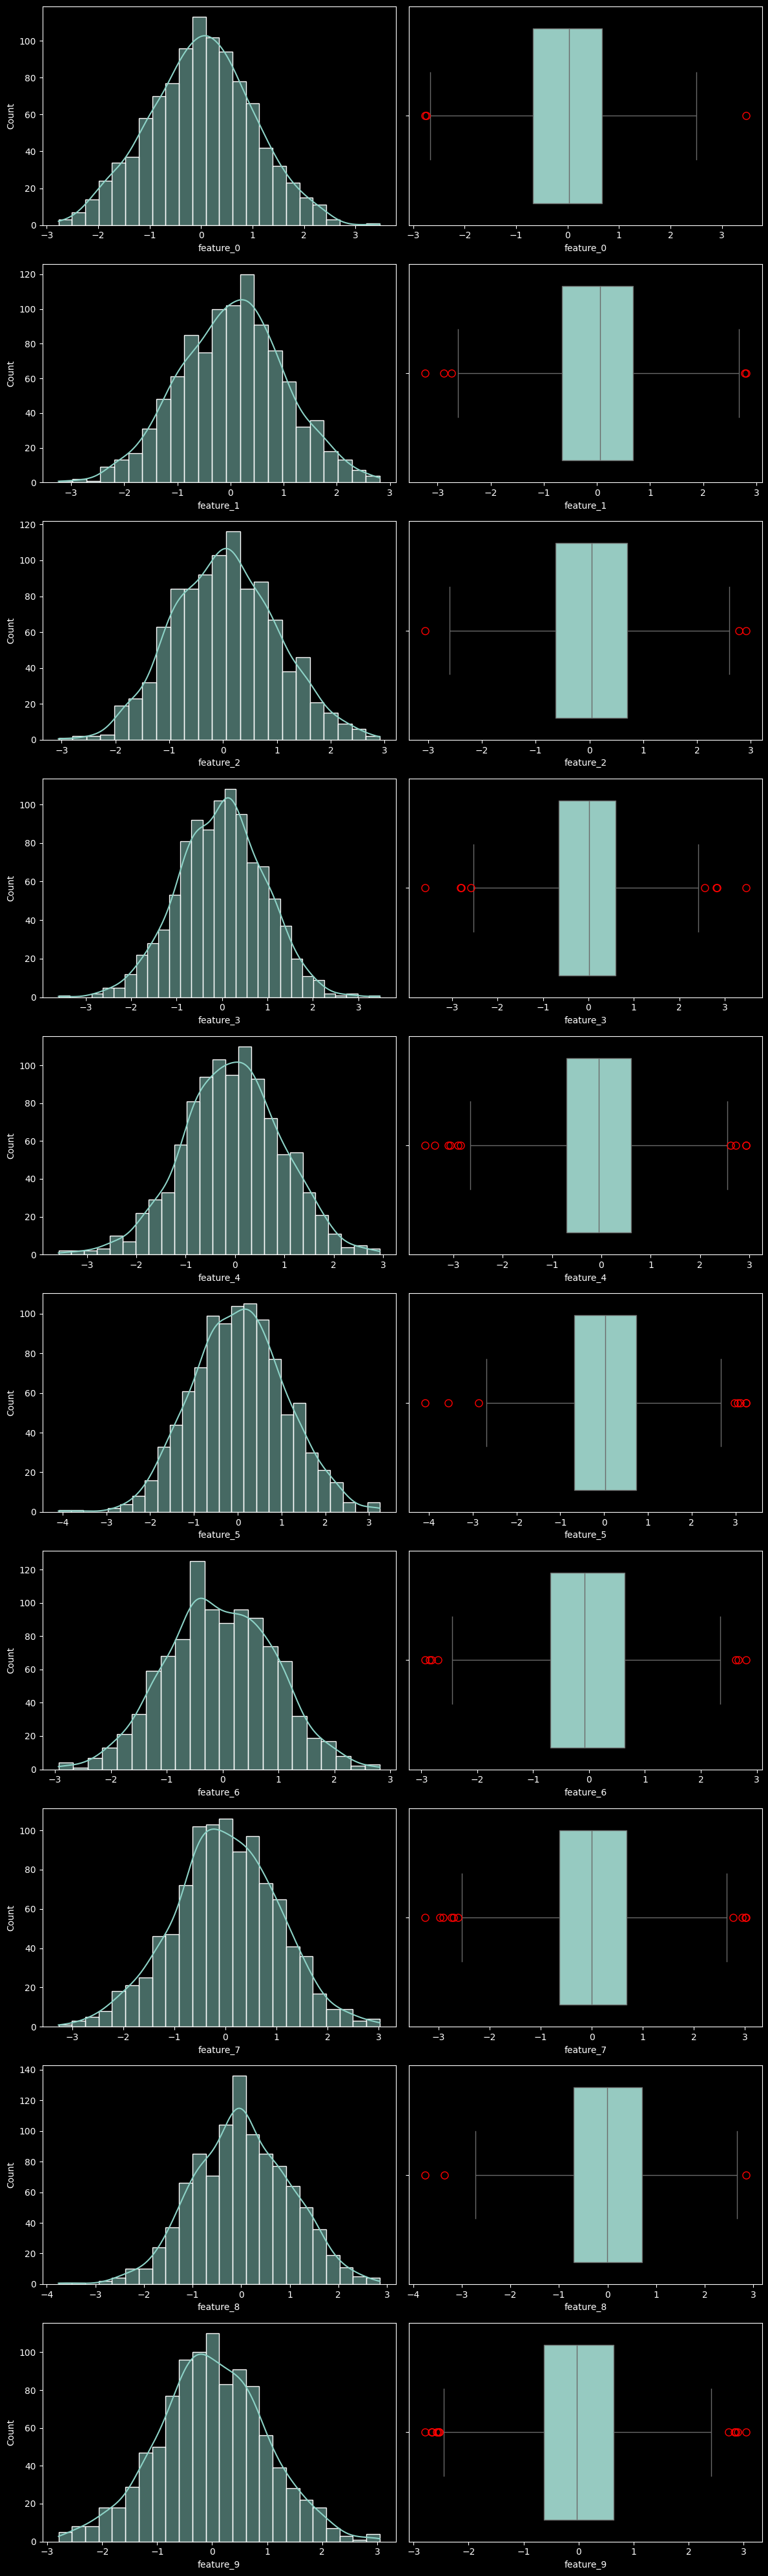

In [11]:
# Plot one under the other pairs (histogram + boxplot)
nrows = df.shape[1] - 1
fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 4 * nrows))

# Customize boxplot colors
flierprops = dict(marker="o", markeredgecolor="red", markersize=8, linestyle="none")

for row, col_name in enumerate(df.drop(columns="target").columns):
    sns.histplot(df[col_name], kde=True, ax=ax[row, 0])
    sns.boxplot(x=df[col_name], ax=ax[row, 1], flierprops=flierprops)
    
plt.tight_layout()
plt.show()

## 4. Outlier & Missing-Value Analysis

- Identification of outliers using summary rules (e.g., values beyond 1.5× IQR or Z-scores greater than `threshold`). For example, "Feature X has 5 outliers beyond 1.5× IQR."
- A discussion of whether to cap, transform, drop them, or leave them as they are. For instance, "Outliers in Feature Y will be capped at the 99th percentile."
- A plan for missing-data handling: which columns to impute (mean, median, KNN), which to drop entirely, and any domain-specific logic (e.g., missing means "unknown").
- A short risk assessment: "Dropping rows will reduce n by 10%; imputing may bias Feature Y."

### missing values

In [12]:
if df.isna().sum().sum() > 0:
    print("There are missing values in the dataset.")
else:
    print("No missing values in the dataset.")

No missing values in the dataset.


### outliers

,Z-score outliers count,IQR outliers count
Feature,,
feature_0,1,3
feature_1,1,5
feature_2,1,3
feature_3,4,8
feature_4,4,10
feature_5,4,8
feature_6,2,7
feature_7,1,10
feature_8,2,3


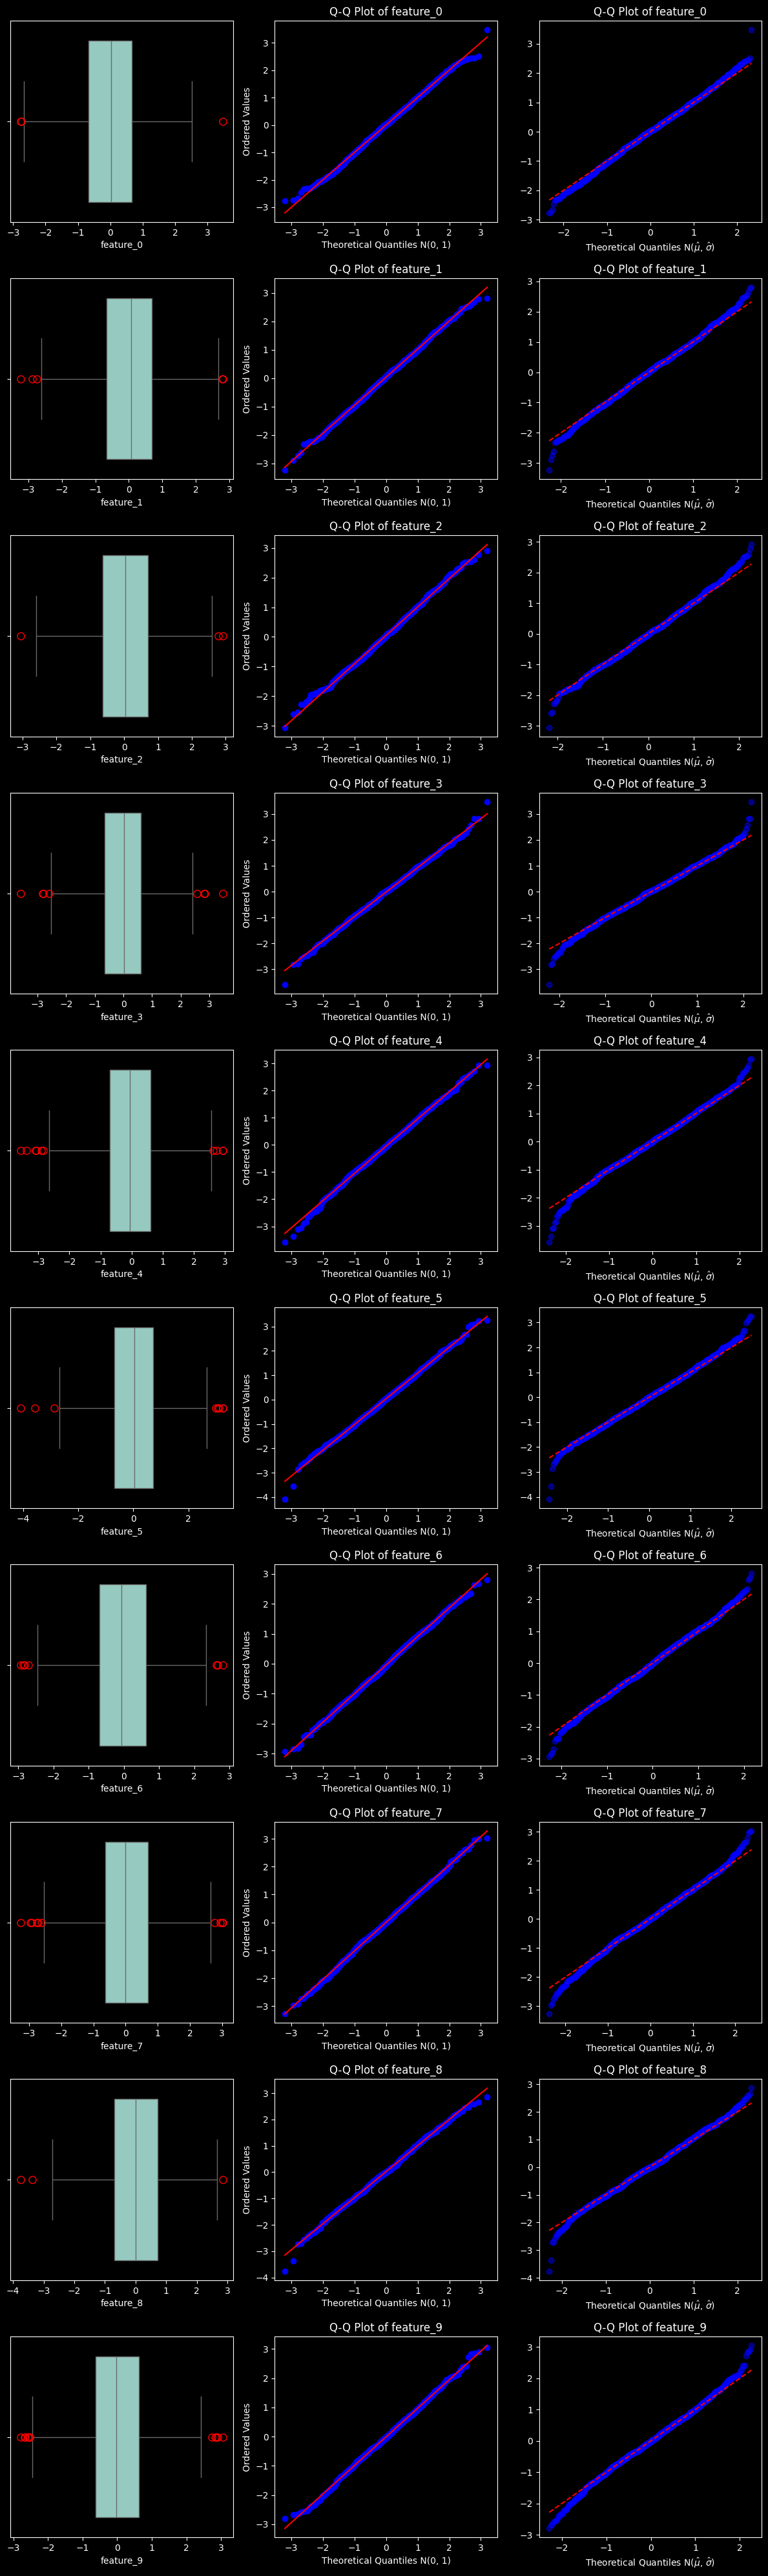

In [13]:
# Plot one under the other: (boxplot + qqplot N(0, 1) + qqplot N(mu, sigma))
# also display outliers with methods Z-score and IQR 
# Do that for each feature in a loop
outlier_summary = []

nrows = df.shape[1] - 1
fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(12, 4 * nrows))

# Customize boxplot colors
flierprops = dict(marker="o", markeredgecolor="red", markersize=8, linestyle="none")

for row, col_name in enumerate(df.drop(columns="target").columns):
    # Z‐score rule
    zs = np.abs(stats.zscore(df[col_name].dropna()))
    z_out = np.sum(zs > 3)
    
    # IQR rule
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    iqr_mask = (df[col_name] < Q1 - 1.5 * IQR) | (df[col_name] > Q3 + 1.5 * IQR)
    iqr_out = iqr_mask.sum()
    
    outlier_summary.append({
        "feature": col_name,
        "zscore_outliers": int(z_out),
        "iqr_outliers": int(iqr_out)
    })

    # Boxplot
    sns.boxplot(x=df[col_name], ax=ax[row, 0], flierprops=flierprops)

    # Q–Q plot - N(0, 1)
    stats.probplot(df[col_name], dist="norm", plot=ax[row, 1])
    ax[row, 1].set_title(f"Q-Q Plot of {col_name}")
    ax[row, 1].set_xlabel("Theoretical Quantiles N(0, 1)")

    # Q–Q plot - N(mu_hat, sigma_hat)
    mu_hat = df[col_name].mean()
    sigma_hat = df[col_name].std()
    theoretical_quantiles = stats.norm.ppf(
        np.linspace(0.01, 0.99, len(df[col_name])), loc=mu_hat, scale=sigma_hat
    )
    ax[row, 2].scatter(theoretical_quantiles, np.sort(df[col_name]), color="blue", alpha=0.5)
    ax[row, 2].plot(
        [theoretical_quantiles.min(), theoretical_quantiles.max()],
        [theoretical_quantiles.min(), theoretical_quantiles.max()],
        color="red",
        linestyle="--",
    )
    ax[row, 2].set_title(f"Q-Q Plot of {col_name}")
    ax[row, 2].set_xlabel(r"Theoretical Quantiles N($\hat{\mu}$, $\hat{\sigma}$)")

outlier_summary = pd.DataFrame(outlier_summary).set_index("feature")
outlier_summary.index.name = "Feature"
outlier_summary.columns = ["Z-score outliers count", "IQR outliers count"]
display(outlier_summary)
    
plt.tight_layout()
plt.show()

- This dataset is generated with `make_regression`, so points flagged by the 3σ rule or the IQR method are simply extreme—but valid—draws from the true distribution, not data‐entry errors. Removing them would artificially reduce the inputs’ variance.  
- Keep in mind that some modeling techniques (for example, OLS‐based stacking) are highly sensitive to leverage points, so you may need to choose methods that mitigate their influence.  
- See the section above for the full discussion of the `target` variable, but in short: you should **not** remove outliers from `y` either.


## 5. Correlation Analysis

- Create a correlation matrix heatmap to visualize pairwise linear relationships among numeric features and the target variable. If the data distribution is far from normal, use Spearman or Kendall correlation methods instead of Pearson.
  - Example: "Feature A and Feature B have a correlation of 0.95, indicating potential multicollinearity."
- Highlight features with strong correlations that might indicate redundancy or multicollinearity concerns. Discuss whether these features should be removed or transformed.
- Discuss any surprising relationships. For instance, "Feature Y and Feature Z are highly correlated despite no obvious domain link."
- Provide guidance on potential feature selection or dimensionality reduction steps. For example:
  - "Features with correlations above 0.8 will be considered for removal to avoid multicollinearity."
  - "Principal Component Analysis (PCA) may be applied to reduce dimensionality while retaining most of the variance."

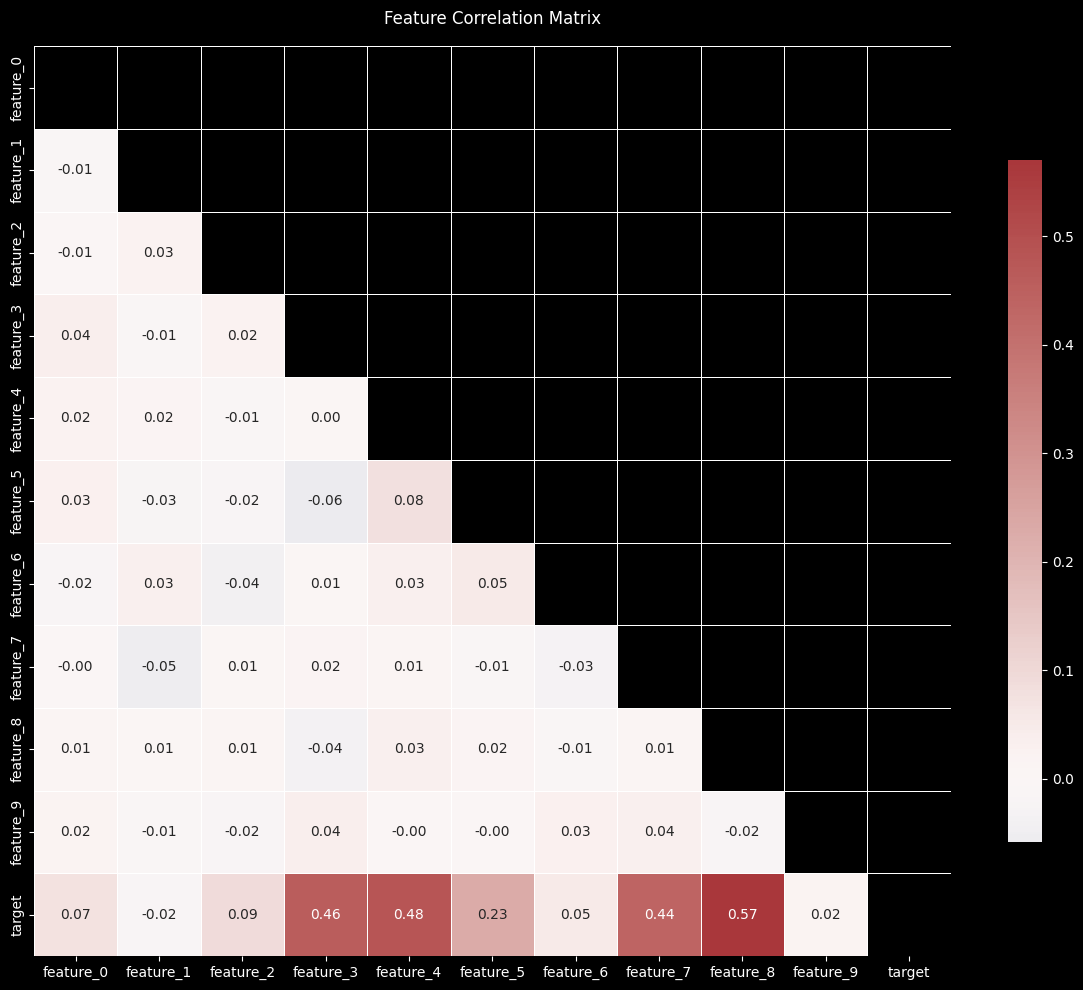

In [15]:
# Compute the correlation matrix (including target if you like)
corr = df.corr()

# Optional: mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    ax=ax
)

ax.set_title("Feature Correlation Matrix", color="white", pad=16)
plt.tight_layout()
plt.show()


In [35]:
# Print max corr between features (excluding target variable)
corr_no_target = df.drop(columns="target").corr()
print(corr_no_target.replace(1, 0).abs().max().max())

0.08006048748993955


In [36]:
# Calculate VIF to double check for multicollinearity concerns
X = df.drop(columns="target")
X_const = add_constant(X)

# Compute VIF for each feature
vif_data = pd.DataFrame({
    "feature": X_const.columns,
    "VIF": [
        variance_inflation_factor(X_const.values, i)
        for i in range(X_const.shape[1])
    ]
})
vif_data = vif_data[vif_data.feature != "const"].reset_index(drop=True)
display(vif_data)

,feature,VIF
0,feature_0,1.004158
1,feature_1,1.006132
2,feature_2,1.003815
3,feature_3,1.009066
4,feature_4,1.009673
5,feature_5,1.014925
6,feature_6,1.009011
7,feature_7,1.006031
8,feature_8,1.003645
9,feature_9,1.004792


- The features exhibit virtually no intercorrelation (maximum absolute correlation ≈ 0.08), so there is no multicollinearity—this is confirmed by the VIF results.  
- By applying a threshold (e.g. |corr(feature, target)| ≥ 0.2), you can drop low-impact variables, leaving only features 3, 4, 5, 7, and 8.


## 6. Multivariate Exploration

- A description of pairwise scatter patterns among top-correlated features and with the target—what shapes (linear, curved, clusters) you see. For example, 
  - "Feature A and Feature B show a linear relationship with some clustering."
  - "Feature X has a strong positive correlation with the target, suggesting it may be a good predictor."
- Insights from a low-dimensional projection (like PCA): whether data forms distinct groups, follows a simple manifold, or exhibits strange clustering. Consider using pair plots or PCA visualizations.
- Any interaction effects you note (e.g., "Feature A only matters when Feature B is high").
- Optional thoughts on unsupervised patterns (e.g., k-means segments) if they seem relevant to downstream stratification or modeling.

In [37]:
corr_with_target = df.corr()["target"].abs().sort_values(ascending=False)
top_feats = corr_with_target.index[1:6]   # skip “target” itself
print("Top features by |corr| to target:", list(top_feats))

Top features by |corr| to target: ['feature_8', 'feature_4', 'feature_3', 'feature_7', 'feature_5']


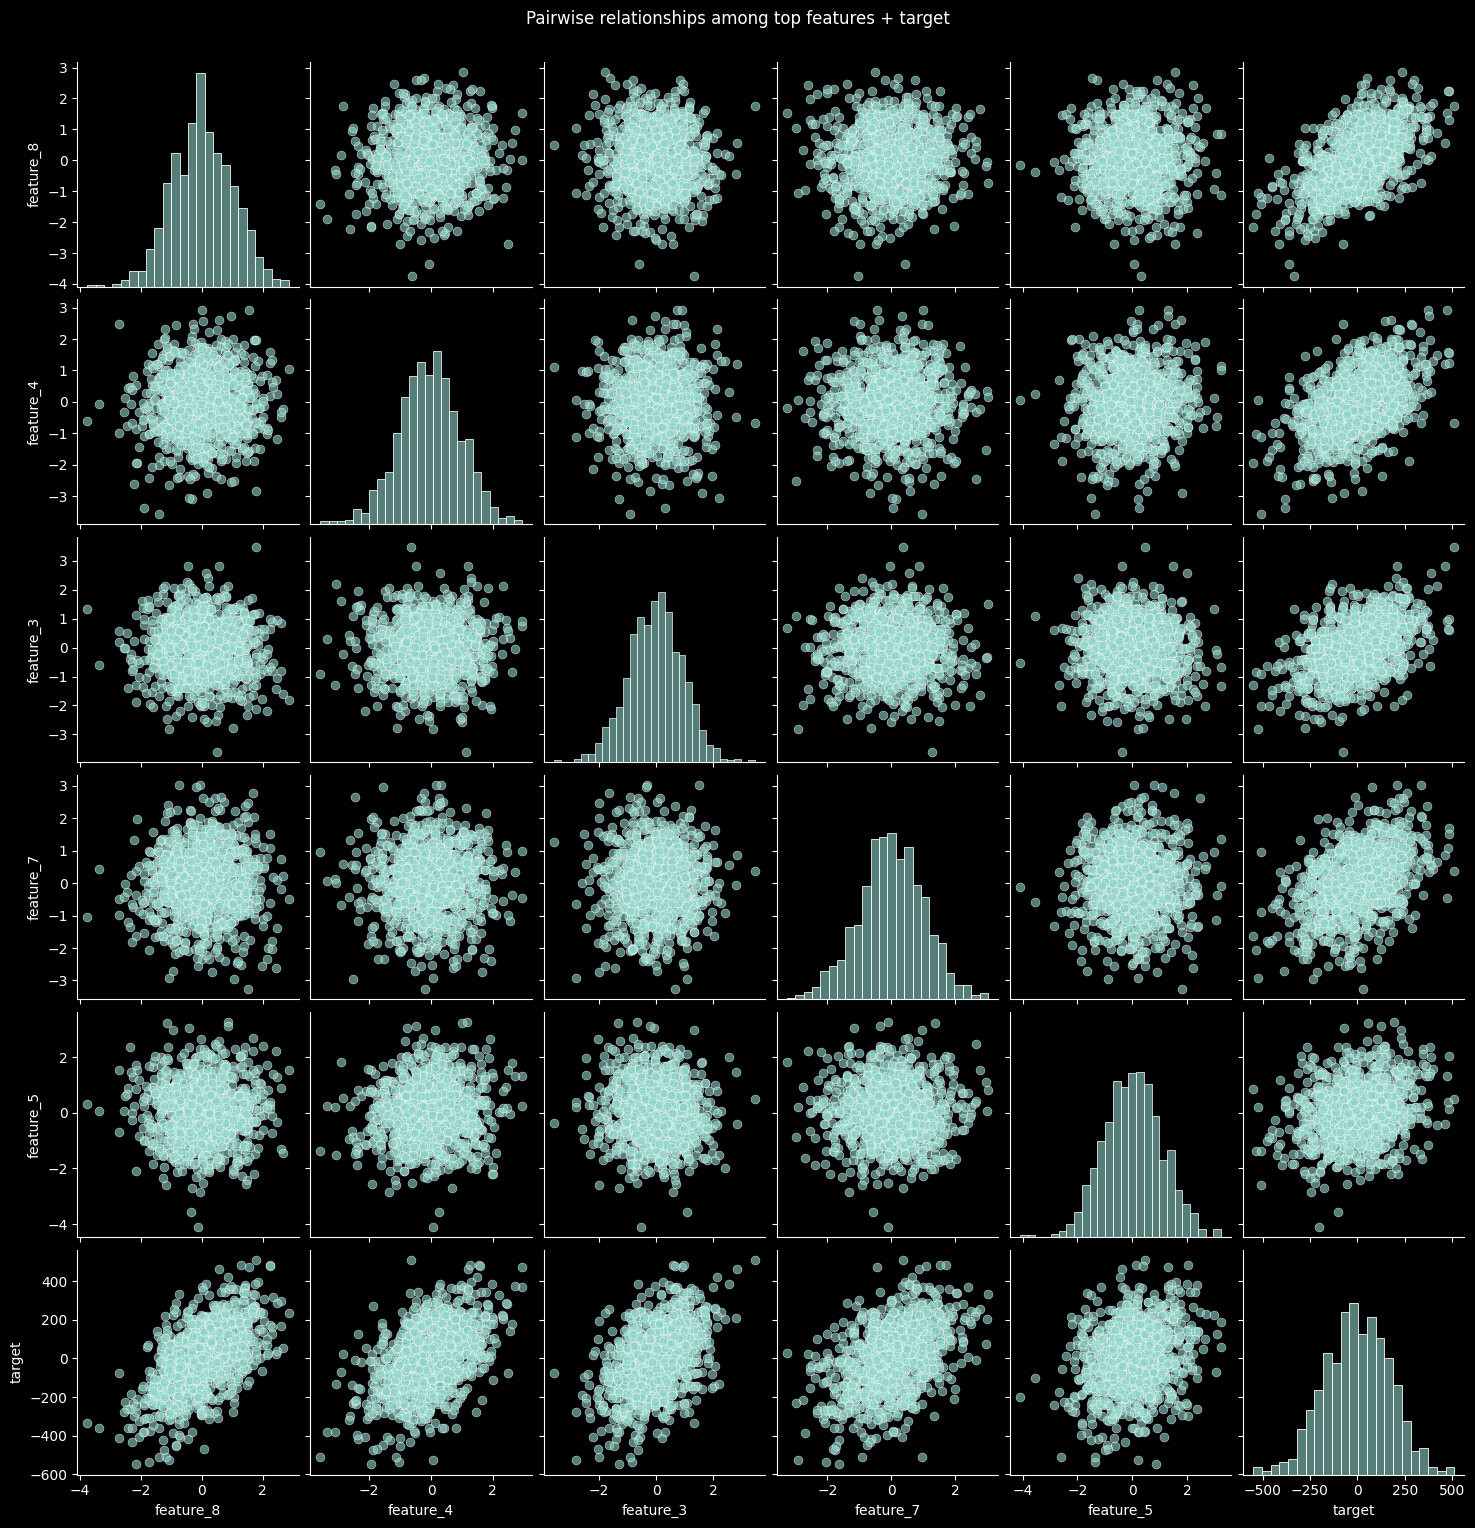

In [38]:
sns.pairplot(
    df[list(top_feats) + ["target"]],
    kind="scatter",
    diag_kind="hist",
    plot_kws={"alpha":0.6, "s":40, "edgecolor":"white"},
    diag_kws={"alpha":0.6}
)
plt.suptitle("Pairwise relationships among top features + target", y=1.02)
plt.show()

- all five features show a linear (no obvious curve) relationship to `target`
- no distinct clusters of points -- one continuous cloud per feature
- the strength of that linear trend tracks exactly with your correlation coefficients: feature_8 > feature_4 ≈ feature_3 > feature_7 > feature_5
- simple linear model (or any method capturing linear trends) is well-suited here, and there’s no obvious need for nonlinear transforms or cluster-based stratification

### feature selection

Previous analysis showed that there is no point looking for additional features with transformations or interactions. But not every feature had high correlation with `"target"`. In this subsection I will explore feature selection methods.

In [ ]:
# 1) Correlation filter: keep only features with |corr(feature, target)| ≥ 0.2
corr = df.corr()["target"].abs().drop("target")
feat_thresh = corr[corr >= 0.2].index.tolist()
print("After correlation filter:", feat_thresh)

X = df[feat_thresh]
y = df["target"]

# 2) Train‐test split for validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# 3) Standardize (important for Lasso)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# 4a) LassoCV feature selection
lasso = LassoCV(cv=5, n_alphas=100, random_state=SEED).fit(X_train_s, y_train)
coefs = pd.Series(lasso.coef_, index=feat_thresh)
selected_lasso = coefs[coefs != 0].index.tolist()
print("Features selected by LassoCV:", selected_lasso)

# 4b) Permutation importance with RandomForest for comparison
rf = RandomForestRegressor(n_estimators=100, random_state=SEED).fit(X_train, y_train)
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=SEED)
perm_imp = pd.Series(perm.importances_mean, index=feat_thresh).sort_values(ascending=False)
print("\nPermutation importances:\n", perm_imp)

# Final selected features (intersection of both methods, for example)
final_features = list(set(selected_lasso) & set(perm_imp[perm_imp > 0].index))
print("\nFinal features (Lasso ∩ RF perm. imp.):", final_features)


After correlation filter: ['feature_3', 'feature_4', 'feature_5', 'feature_7', 'feature_8']
Features selected by LassoCV: ['feature_3', 'feature_4', 'feature_5', 'feature_7', 'feature_8']

Permutation importances:
 feature_8    0.522573
feature_3    0.368352
feature_4    0.320291
feature_7    0.246826
feature_5    0.053929
dtype: float64

Final features (Lasso ∩ RF perm. imp.): ['feature_7', 'feature_4', 'feature_3', 'feature_8', 'feature_5']


In [44]:
# 1) Prepare full feature matrix and target
X_all = df.drop(columns="target")
y = df["target"]

# 2) Identify “low-correlation” features by a 0.2 abs(corr) threshold
corr_with_y = X_all.corrwith(y).abs()
low_corr_feats = corr_with_y[corr_with_y < 0.2].index.tolist()
print("Low-corr features (<0.2):", low_corr_feats)

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.2, random_state=42
)

# 4) Standardize for Lasso
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# 5) LassoCV on all features
lasso = LassoCV(cv=5, random_state=0).fit(X_train_s, y_train)
coef_series = pd.Series(lasso.coef_, index=X_all.columns)
selected_lasso = coef_series[coef_series != 0].index.tolist()
print("\nLassoCV selected features:", selected_lasso)

# 6) Permutation importance via RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=0)
perm_imp = pd.Series(perm.importances_mean, index=X_all.columns).sort_values(ascending=False)
selected_perm = perm_imp[perm_imp > 0].index.tolist()
print("\nRF permutation-important features (>0 importance):", selected_perm)

# 7) Compare to low-corr list
kept_by_lasso     = [f for f in low_corr_feats if f in selected_lasso]
dropped_by_lasso  = [f for f in low_corr_feats if f not in selected_lasso]

kept_by_perm      = [f for f in low_corr_feats if f in selected_perm]
dropped_by_perm   = [f for f in low_corr_feats if f not in selected_perm]

print(f"\nLow-corr feats kept by LassoCV:    {kept_by_lasso}")
print(f"Low-corr feats dropped by LassoCV: {dropped_by_lasso}")

print(f"\nLow-corr feats kept by RF perm imp:    {kept_by_perm}")
print(f"Low-corr feats dropped by RF perm imp: {dropped_by_perm}")


Low-corr features (<0.2): ['feature_0', 'feature_1', 'feature_2', 'feature_6', 'feature_9']

LassoCV selected features: ['feature_0', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8']

RF permutation-important features (>0 importance): ['feature_8', 'feature_3', 'feature_4', 'feature_7', 'feature_5', 'feature_2', 'feature_6', 'feature_1']

Low-corr feats kept by LassoCV:    ['feature_0', 'feature_2', 'feature_6']
Low-corr feats dropped by LassoCV: ['feature_1', 'feature_9']

Low-corr feats kept by RF perm imp:    ['feature_1', 'feature_2', 'feature_6']
Low-corr feats dropped by RF perm imp: ['feature_0', 'feature_9']


Feature Selection Report

- **Inter‐method summary**  
  - **Correlation** (>=0.2):  : `feature_3`, `feature_4`, `feature_5`, `feature_7`, `feature_8`
  - **LassoCV ∩ RF perm‐imp** selected: `feature_2`, `feature_3`, `feature_4`, `feature_5`, `feature_6`, `feature_7`, `feature_8`  
  - **LassoCV ∪ RF perm‐imp** (all but `feature_9`):  
    `feature_0`, `feature_1`, `feature_2`, `feature_3`, `feature_4`, `feature_5`, `feature_6`, `feature_7`, `feature_8`  

- **Recommendation**  
  - **Drop** `feature_9` (never selected by any method).  
  - **Keep** the other nine features for bagging and boosting models; they’ll handle any residual noise.  
  - If you need a minimal set, use the **intersection** of LassoCV and RF perm‐imp.

## 7. Feature Engineering Plan

- A bullet list of transformations you intend to apply: log or power transforms for skewed distributions, scaling or normalization for models that require it.
- Ideas for derived features: interactions, polynomial terms, binning of continuous variables, or aggregations if relevant.
- Notes on how to encode categorical variables (one-hot, ordinal) and any thresholds (e.g., group rare categories under "Other").
- A rationale for each choice—how it might help bagging, boosting, or stacking models.
- Validate the effectiveness of engineered features by checking feature importance scores or model performance after training.

1. No need for extra features -- every relationship that is present is linear
2. Drop feature 9 

## 8. Preprocessing Pipeline Outline

- Short, step-by-step list of the operations in the order they should run in pipeline:
  1. Missing-value imputation
  2. Outlier capping or removal (and optional imputation of removed outliers)
  3. Feature transforms and scaling
  4. Train/test split configuration -- only if data analysis suggests that specific train/test split could be beneficial / is mandatory (for example time series data)

1. Is scaling needed?
  - Boosting
    - Tree-based boosters (XGBoost, LightGBM, CatBoost) are invariant to monotonic rescaling of inputs — skip scaling there.
    - Gradient-descent based models (e.g. AdaBoost with a linear or neural‐net base learner) do benefit from inputs on the same scale to speed up convergence and improve regularization.
  - Bagging
    - Tree ensembles (Random Forest, Bagged Trees) again don’t need scaling.
    - If you’re bagging any distance-based or kernel learners (KNN, SVM, RBF models), you should scale so no one feature dominates the distance metric.
  - Stacking
    - Base learners should each handle scaling as appropriate: trees skip it, linear/SVM/NN/KNN models get a scaler.
    - Meta-learner (often a linear model) sees the predictions of level-0 models, not raw features — so it typically doesn’t need feature scaling, only that its inputs (the stacked predictions) are on comparable scales if you’re blending heterogeneous outputs.
2. No advanced pipeline is needed here -- simply drop `feature_9` from the set